In [1]:
import gym
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
from gym import spaces

C:\ProgramData\Miniconda3\lib\site-packages\flatbuffers\compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
C:\ProgramData\Miniconda3\lib\site-packages\keras\utils\image_utils.py:36: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': pil_image.NEAREST,
C:\ProgramData\Miniconda3\lib\site-packages\keras\utils\image_utils.py:37: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  'bilinear': pil_image.BILINEAR,
C:\ProgramData\Miniconda3\lib\site-packages\keras\utils\image_utils.py:38: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  'bicubic': pil_image.BICUBIC,
C:\ProgramData\Miniconda3\lib\site-packages\keras\utils\image_utils.py:39: DeprecationWar

In [2]:
rng = np.random.default_rng(358)

In [3]:
disc_num_actions = 4

In [4]:
# https://www.gymlibrary.ml/environments/box2d/lunar_lander/

In [5]:
# Using OU Noise
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

def get_actor(num_states, num_actions=1, upper_bound=1, continuous=True, layer1=400, layer2=300):
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(layer1, activation="relu")(inputs)
    out = layers.Dense(layer2, activation="relu")(out)
    
    # Different output activation based on discrete or continous version
    if continuous:
        outputs = layers.Dense(num_actions, activation="tanh", kernel_initializer=last_init)(out)
    else:
        outputs = layers.Dense(1, activation="softmax", kernel_initializer=last_init)(out)

    # Multiply to fill the whole action space which should be equal around 0
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model

def get_critic(num_states, num_actions=1, layer1=400, layer2=300):
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)

    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(layer1, activation="relu")(concat)
    out = layers.Dense(layer2, activation="relu")(out)

    outputs = layers.Dense(num_actions)(out)

    # Make it into a keras model
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

# This updates the weights in a slow manner which keeps stability
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

In [18]:
class Agent:
    def __init__(self, num_states, num_actions=1, lower_bound=1, upper_bound=1, continuous=True,
            buffer_capacity=50000, batch_size=64, std_dev=0.2, critic_lr=0.002,
            actor_lr=0.001, gamma=0.99, tau=0.005, epsilon=0.2, adam_critic_eps=1e-07,
            adam_actor_eps=1e-07):
        
        self.buffer_capacity = buffer_capacity
        self.batch_size = batch_size
        
        # For methods
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.continuous = continuous

        # This is used to make sure we only sample from used buffer space
        self.buffer_counter = 0

        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))
        
        # have to change type for gradient calculation
        self.done_buffer = np.zeros((self.buffer_capacity, 1)).astype(np.float32)
        
        self.std_dev = std_dev
        self.critic_lr = critic_lr
        self.actor_lr = actor_lr
        self.gamma = gamma
        self.tau = tau
        
        self.epsilon = epsilon
        
        self.actor_model = get_actor(num_states, num_actions, upper_bound, continuous=continuous, layer1=400, layer2=300)
        self.critic_model = get_critic(num_states, num_actions, layer1=400, layer2=300)

        self.target_actor = get_actor(num_states, num_actions, upper_bound, continuous=continuous, layer1=400, layer2=300)
        self.target_critic = get_critic(num_states, num_actions, layer1=400, layer2=300)
        
        self.critic_optimizer = tf.keras.optimizers.Adam(
            learning_rate=critic_lr,beta_1=0.9,beta_2=0.999,epsilon=adam_critic_eps
        )
        self.actor_optimizer = tf.keras.optimizers.Adam(
            learning_rate=actor_lr,beta_1=0.9,beta_2=0.999,epsilon=adam_actor_eps
        )
        
        # Making the weights equal initially
        self.target_actor.set_weights(self.actor_model.get_weights())
        self.target_critic.set_weights(self.critic_model.get_weights())
        
        self.ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))
    
    # Makes a record of the outputted (s,a,r,s') obervation tuple + terminal state
    def record(self, obs_tuple):
        # Reuse the same buffer replacing old entries
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]
        
        self.done_buffer[index] = obs_tuple[4]

        self.buffer_counter += 1
    
    # Move the update and learn function from buffer to Agent to "decrease" scope
    @tf.function
    def update(self, state_batch, action_batch, reward_batch, next_state_batch, done_batch):
        with tf.GradientTape() as tape:
            target_actions = self.target_actor(next_state_batch, training=True)
            # Add done_batch to y function for terminal state
            y = reward_batch + done_batch * self.gamma * self.target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = self.critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, self.critic_model.trainable_variables)
        
        # Gradient clipping to avoid exploding and vanishing gradients
        critic_gvd = zip(critic_grad, self.critic_model.trainable_variables)
        critic_capped_grad = [(tf.clip_by_value(grad, clip_value_min=-1, clip_value_max=1), var) for grad, var in critic_gvd]
        
        self.critic_optimizer.apply_gradients(critic_capped_grad)

        with tf.GradientTape() as tape:
            actions = self.actor_model(state_batch, training=True)
            critic_value = self.critic_model([state_batch, actions], training=True)

            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, self.actor_model.trainable_variables)
        # clip actor too
        actor_gvd = zip(actor_grad, self.actor_model.trainable_variables)
        actor_capped_grad = [(tf.clip_by_value(grad, clip_value_min=-1, clip_value_max=1), var) for grad, var in actor_gvd]
        
        self.actor_optimizer.apply_gradients(actor_capped_grad)

    # We compute the loss and update parameters
    def learn(self):
        # Sample only valid data
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])
        # Add done_batch for terminal state
        done_batch = tf.convert_to_tensor(self.done_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch, done_batch)
        
    def policy(self, state, noise_object=0, use_noise=True, noise_mult=1):
        # Default noise_object to 0 for when it is not needed
        # For doing actions without added noise
        if not use_noise:    
            if self.continuous:
                sampled_actions = tf.squeeze(self.actor_model(state)).numpy()
                legal_action = np.clip(sampled_actions, self.lower_bound, self.upper_bound)
                return [np.squeeze(legal_action)]
            else:
                sampled_actions = tf.squeeze(self.actor_model(state)).numpy()
                legal_action = np.clip(sampled_actions, self.lower_bound, self.upper_bound)
                return int(legal_action)
        else:
            if self.continuous:
                sampled_actions = tf.squeeze(self.actor_model(state))
                noise = noise_object()
                # Adding noise to action
                sampled_actions = sampled_actions.numpy() + noise * noise_mult

                # We make sure action is within bounds
                legal_action = np.clip(sampled_actions, self.lower_bound, self.upper_bound)
                
                return [np.squeeze(legal_action)]
            
            else:
                if (rng.random() < self.epsilon):
                    #random move
                    #gets random non-nan index
                    return rng.choice(np.arange(0, disc_num_actions, 1, dtype=int))
                else:
                    sampled_actions = tf.squeeze(self.actor_model(state)).numpy()
                    legal_action = np.clip(sampled_actions, self.lower_bound, self.upper_bound)
                    return max(0, min(disc_num_actions, int(legal_action)))

In [19]:
def fixed(x, episode):
    return x

In [20]:
def run(total_trials=1, total_episodes=100, 
            buffer_capacity=50000, batch_size=64, std_dev=0.3, critic_lr=0.003, render=False,
            actor_lr=0.002, gamma=0.99, tau=0.005, noise_mult=1, save_weights=True, 
            directory='Weights/', actor_name='actor', critic_name='critic',
            gamma_func=fixed, tau_func=fixed, critic_lr_func=fixed, actor_lr_func=fixed,
            noise_mult_func=fixed, std_dev_func=fixed, mean_number=20, output=True,
            return_rewards=False, total_time=True, use_guide=False, solved=200,
            continuous=True, environment='LunarLander-v2', seed=1453, start_steps=0,
            gravity=-10.0, enable_wind=False, wind_power=15.0, turbulence_power=1.5,
            epsilon=0.2, epsilon_func=fixed, adam_critic_eps=1e-07, adam_actor_eps=1e-07):
    tot_time = time.time()
    
    if environment == 'LunarLander-v2':
        env = gym.make(
            "LunarLander-v2",
            continuous=continuous,
            gravity=gravity,
            enable_wind=enable_wind,
            wind_power=wind_power,
            turbulence_power=turbulence_power
        )
    else:
        env = gym.make(environment)
        
    # Apply the seed
    _ = env.reset(seed=seed)
        
    # This is needed to get the input size for the NN
    num_states = env.observation_space.low.shape[0]
    if continuous:
        num_actions = env.action_space.shape[0]
    else:
        num_actions = 1

    # Normalize action space according to https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
    action_space = spaces.Box(low=-1, high=1, shape=(num_actions,), dtype='float32')

    # This is needed to clip the actions within the legal boundaries
    upper_bound = action_space.high[0]
    lower_bound = action_space.low[0]
    
    # To store reward history of each episode
    ep_reward_list = []
    # To store average reward history of last few episodes
    avg_reward_list = []
    # To separate assisted reward structures from the "true"
    true_reward_list = []
    true_avg_reward_list = []
    
    for trial in range(total_trials):
        
        # Stepcount for random start
        step = 0

        # add sublists for each trial
        avg_reward_list.append([])
        ep_reward_list.append([])
        
        true_reward_list.append([])
        true_avg_reward_list.append([])
        
        agent = Agent(num_states=num_states, num_actions=num_actions, lower_bound=lower_bound, 
                upper_bound=upper_bound, continuous=continuous, buffer_capacity=buffer_capacity, 
                batch_size=batch_size, std_dev=std_dev, critic_lr=critic_lr, actor_lr=actor_lr, 
                gamma=gamma, tau=tau, epsilon=epsilon, adam_critic_eps=adam_critic_eps, adam_actor_eps=adam_actor_eps)

        for ep in range(total_episodes):
            # functions for different parameters
            agent.gamma = gamma_func(gamma, ep)
            agent.tau = tau_func(tau, ep)
            agent.critic_lr = critic_lr_func(critic_lr, ep)
            agent.actor_lr = actor_lr_func(actor_lr, ep)
            agent.noise_mult = noise_mult_func(noise_mult, ep)
            agent.std_dev = std_dev_func(std_dev, ep)
            
            agent.epsilon = epsilon_func(epsilon, ep)
            
            # Used for time benchmarking
            before = time.time()

            prev_state = env.reset()
            episodic_reward = 0
            true_reward = 0

            while True:
                if render:
                    env.render()
                
                tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

                if step >= start_steps:
                    action = agent.policy(state=tf_prev_state, noise_object=agent.ou_noise, noise_mult=noise_mult)
                    # To get the right format
                    if continuous:
                        action = action[0]
                else:
                    action = env.action_space.sample()
                
                step += 1
                
                # Recieve state and reward from environment.
                state, reward, done, info = env.step(action)
                
                # Add this before eventual reward modification
                true_reward += reward
                
                # Reward modification
                if use_guide:
                    # giving penalty for straying far from flags and having high speed
                    # x max
#                     reward -= int(abs(state[0]) > 0.15) * 2 * abs(state[0])
#                     # y top
#                     reward -= int(state[1] > 1) * state[1] / 2
#                     # horizontal speed
#                     reward -= int(abs(state[2]) > 1) * abs(state[2])
#                     # down speed
#                     reward -= int(state[3] <  -1) * abs(state[3])
#                     # up speed
#                     reward -= int(state[3] > 0.1) * 3 * state[3]
                    reward -= abs(state[2]/2) + abs(state[3]) + (abs(state[0])) + (abs(state[1])/2)

                # Add terminal state for when it has landed. Just look at legs on the ground
                terminal_state = int(state[6] and state[7])
                
                agent.record((prev_state, action, reward, state, terminal_state))
                episodic_reward += reward

                agent.learn()
                update_target(agent.target_actor.variables, agent.actor_model.variables, agent.tau)
                update_target(agent.target_critic.variables, agent.critic_model.variables, agent.tau)

                # End this episode if en episode is done
                if done:
                    break

                prev_state = state

            ep_reward_list[trial].append(episodic_reward)
            
            true_reward_list[trial].append(true_reward)
            
            true_avg_reward = np.mean(true_reward_list[trial][-mean_number:])
            true_avg_reward_list[trial].append(true_avg_reward)

            # Mean of last x episodes
            avg_reward = np.mean(ep_reward_list[trial][-mean_number:])
            if output:
                print("Ep {} * AvgReward {:.2f} * true AvgReward {:.2f} * Reward {:.2f} * True Reward {:.2f} * time {:.2f} * step {}"
                  .format(ep, avg_reward, true_avg_reward, episodic_reward, true_reward, (time.time() - before), step))
            avg_reward_list[trial].append(avg_reward)
            
            # stop if avg is solved
            if true_avg_reward >= solved:
                break

        # Save weights naming
        now = datetime.datetime.now()
        timestamp = "{}.{}.{}.{}.{}.{}".format(now.year, now.month, now.day, now.hour, now.minute, now.second)
        save_name = "{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}".format(
            environment, total_episodes, 
            buffer_capacity, batch_size, 
            std_dev, critic_lr, actor_lr, 
            gamma, tau, noise_mult, 
            gamma_func.__name__, tau_func.__name__, 
            critic_lr_func.__name__, actor_lr_func.__name__, 
            noise_mult_func.__name__, std_dev_func.__name__, 
            mean_number, use_guide, 
            solved, continuous, 
            start_steps, gravity, 
            enable_wind, wind_power,
            turbulence_power, 
            epsilon, epsilon_func,
            timestamp,
        )
        if save_weights:
            try:
                agent.actor_model.save_weights(directory + actor_name + '-trial' + str(trial) + '_' + save_name + '.h5')
            except:
                print('actor save fail')
            try:
                agent.critic_model.save_weights(directory + critic_name + '-trial' + str(trial) + '_' + save_name + '.h5')
            except:
                print('critic save fail')
    
    # Plotting graph
    for idx, p in enumerate(true_avg_reward_list):
        plt.plot(p, label=str(idx))
    plt.xlabel("Episode")
    plt.ylabel("True Avg. Epsiodic Reward (" + str(mean_number) + ")")
    plt.legend()
    plt.savefig('Graphs/' + save_name + '.png')
    plt.show()
    
    print('total time:',time.time() - tot_time, 's')
    
    # Return to be able to make graphs etc. later, or use the data for other stuff
    if return_rewards:
        return true_reward_list

In [21]:
def test(total_episodes=10, actor_weights='Weights/actor-trial0.h5', render=False,
        environment="LunarLander-v2", continuous=True, gravity=-10.0, enable_wind=False,
        wind_power=15.0, turbulence_power=1.5, seed=1453):
    rewards = []
    
    env = gym.make(
        environment,
        continuous=continuous,
        gravity=gravity,
        enable_wind=enable_wind,
        wind_power=wind_power,
        turbulence_power=turbulence_power
    )
    
    # This is needed to get the input size for the NN
    num_states = env.observation_space.low.shape[0]
    if continuous:
        num_actions = env.action_space.shape[0]
    else:
        num_actions = 1

    # Normalize action space according to https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
    action_space = spaces.Box(low=-1, high=1, shape=(num_actions,), dtype='float32')

    # This is needed to clip the actions within the legal boundaries
    upper_bound = action_space.high[0]
    lower_bound = action_space.low[0]
    
    # Apply the seed
    _ = env.reset(seed=seed)
    
    for ep in range(total_episodes):
        ep_reward = 0
        
        # Used for time benchmarking
        before = time.time()
        
        prev_state = env.reset()
        agent = Agent(num_states=num_states, num_actions=num_actions, lower_bound=lower_bound, 
                upper_bound=upper_bound, continuous=continuous, buffer_capacity=0, batch_size=0, 
                std_dev=0, critic_lr=0, actor_lr=0, gamma=0, tau=0, epsilon=0)
        agent.actor_model.load_weights(actor_weights)
        
        while True:
            if render:
                env.render()

            tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

            action = agent.policy(state=tf_prev_state, use_noise=False)
            if continuous:
                action = action[0]
            state, reward, done, _ = env.step(action)
            
            ep_reward += reward

            if done:
                print(str(time.time() - before) + 's')
                rewards.append(ep_reward)
                break

            prev_state = state
            
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("True reward")
    plt.show()

In [22]:
def random(total_episodes=10, render=False, environment="LunarLander-v2", continuous=True,
        gravity=-10.0, enable_wind=False, wind_power=15.0, turbulence_power=1.5, seed=1453):
    rewards = []
    
    env = gym.make(
        environment,
        continuous=continuous,
        gravity=gravity,
        enable_wind=enable_wind,
        wind_power=wind_power,
        turbulence_power=turbulence_power,
    )
    
    # Apply the seed
    _ = env.reset(seed=seed)
    
    for ep in range(total_episodes):
        ep_reward = 0
        
        # Used for time benchmarking
        before = time.time()
        
        prev_state = env.reset()
        
        while True:
            if render:
                env.render()
            action = env.action_space.sample()
            state, reward, done, _ = env.step(action)
            ep_reward += reward

            if done:
                print(str(time.time() - before) + 's')
                rewards.append(ep_reward)
                break

            prev_state = state
            
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("True reward")
    plt.show()

---
# Runs and tests
---

In [23]:
xax = [x for x in range(-600,250)]

In [24]:
def decreasing_std(x, episode):
    return max(0, min(0.2, 0.2 - (x+500)*(0.2/700)))

In [25]:
def decreasing_alr(x, episode):
    return max(0, min(0.001, 0.001 - (x+500)*(0.001/700)))

In [26]:
def decreasing_clr(x, episode):
    return max(0, min(0.002, 0.002 - (x+500)*(0.002/700)))

In [27]:
def decreasing_eps(x, episode):
    return max(0, min(0.2, 0.2 - (x+500)*(0.2/700)))

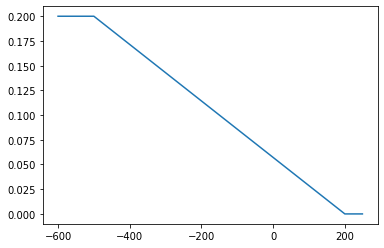

In [28]:
plt.plot(xax,[decreasing_std(x,1) for x in range(-600,250)])

In [ ]:
run(total_trials=1, total_episodes=100, buffer_capacity=300000, tau=0.001, critic_lr=0.0002, 
    actor_lr=0.0001, start_steps=10000, continuous=True)

Ep 0 * AvgReward -120.23 * true AvgReward -120.23 * Reward -120.23 * True Reward -120.23 * time 2.65 * step 134
Ep 1 * AvgReward -112.31 * true AvgReward -112.31 * Reward -104.39 * True Reward -104.39 * time 0.76 * step 210
Ep 2 * AvgReward -79.85 * true AvgReward -79.85 * Reward -14.94 * True Reward -14.94 * time 0.89 * step 294
Ep 3 * AvgReward -116.55 * true AvgReward -116.55 * Reward -226.64 * True Reward -226.64 * time 1.95 * step 456
Ep 4 * AvgReward -128.34 * true AvgReward -128.34 * Reward -175.49 * True Reward -175.49 * time 1.19 * step 559
Ep 5 * AvgReward -146.17 * true AvgReward -146.17 * Reward -235.34 * True Reward -235.34 * time 1.08 * step 661
Ep 6 * AvgReward -167.95 * true AvgReward -167.95 * Reward -298.62 * True Reward -298.62 * time 1.50 * step 798
Ep 7 * AvgReward -156.81 * true AvgReward -156.81 * Reward -78.82 * True Reward -78.82 * time 0.80 * step 868
Ep 8 * AvgReward -171.97 * true AvgReward -171.97 * Reward -293.30 * True Reward -293.30 * time 0.95 * step 95